In [1]:
import sys ; sys.path.insert(0, '../')
from notebook_tools import *
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
%matplotlib inline
from scipy.interpolate import interp1d

In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/'

In [3]:
columns = ['Pmiss3Mag','pcmX','pcmY','pcmZ','rooWeight','Plead_P','Plead_theta','Plead_phi','Precoil_P','Precoil_theta','Precoil_phi','electron_phi','electron_theta'] # ,'Mott','DipoleFF2'
data_allPmiss_PrecFid , data300Pmiss600_PrecFid = dict() , dict()
for target in ['C12','Al27','Fe56','Pb208']:
    data_allPmiss_PrecFid[target] = read_root( path+"/OrAnalysisTrees/AdjustedTrees/SRC_e2p_adjusted_300Pmiss1000_%s_PrecFiducials.root"%target, columns=columns )
    data300Pmiss600_PrecFid[target] = read_root( path+"/OrAnalysisTrees/AdjustedTrees/SRC_e2p_adjusted_300Pmiss600_%s_PrecFiducials.root"%target, columns=columns )

In [4]:
cm_parameters = dict()
cm_parameters_with_correction = dict()
for Fiducials in ["PrecFiducials","NoPrecFiducials"]:
    cm_pars = pd.read_csv('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/300Pmiss600/alltargets_'+Fiducials+'_dataCMparameters.csv')

    for direction in ['x','y']:
        cm_pars['sigma_'+direction+'_before_acc_corr'] = np.sqrt(np.square(cm_pars['sigma_'+direction+'_unweighted']) - np.square(0.02))
        cm_pars['sigma_'+direction+'_before_acc_corr_err'] = cm_pars['sigma_'+direction+'Err_unweighted']

    cm_parameters[Fiducials] = cm_pars
    cm_parameters_with_correction[Fiducials] = cm_pars
    
cm_pars = cm_parameters['PrecFiducials']

## fit with RooPlot

saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/MeasuredDistributionC12.pdf
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/MeasuredDistributionAl27.pdf
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/MeasuredDistributionFe56.pdf
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/MeasuredDistributionPb208.pdf


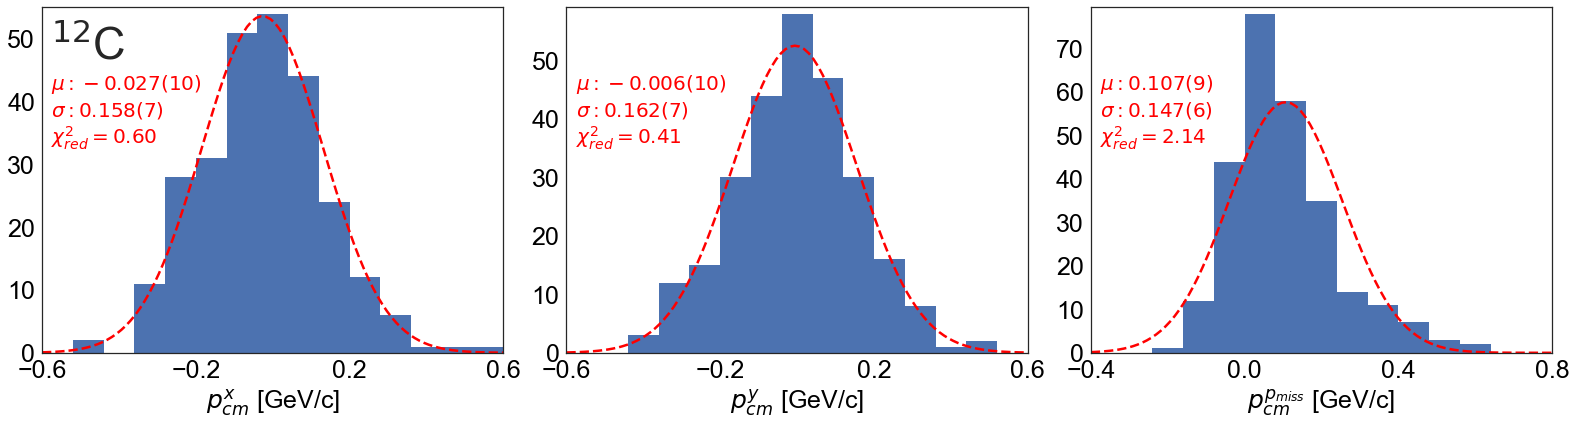

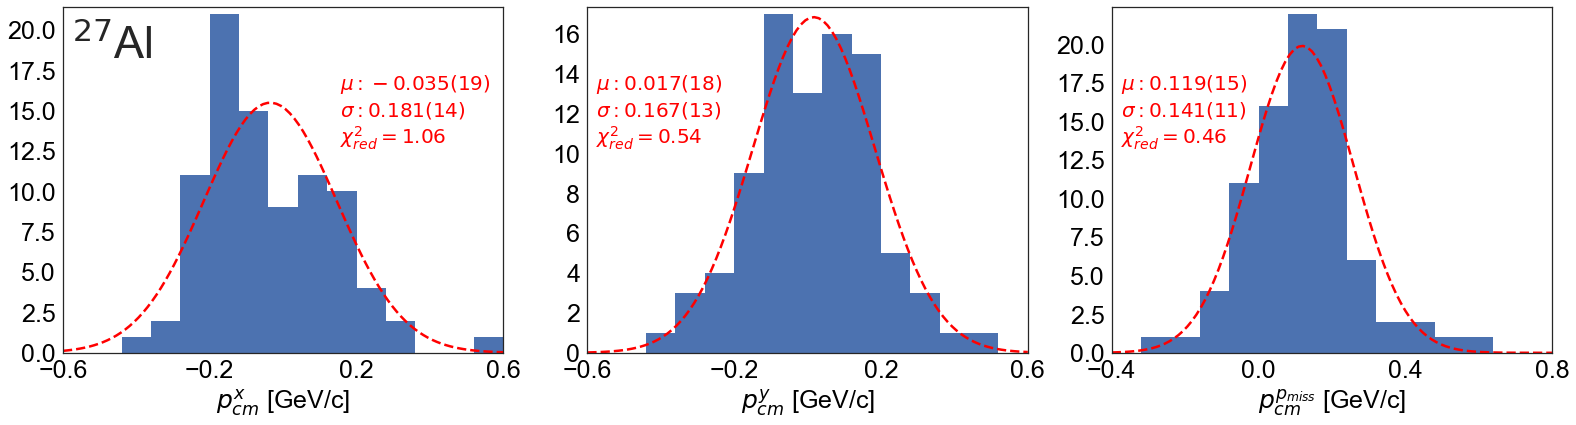

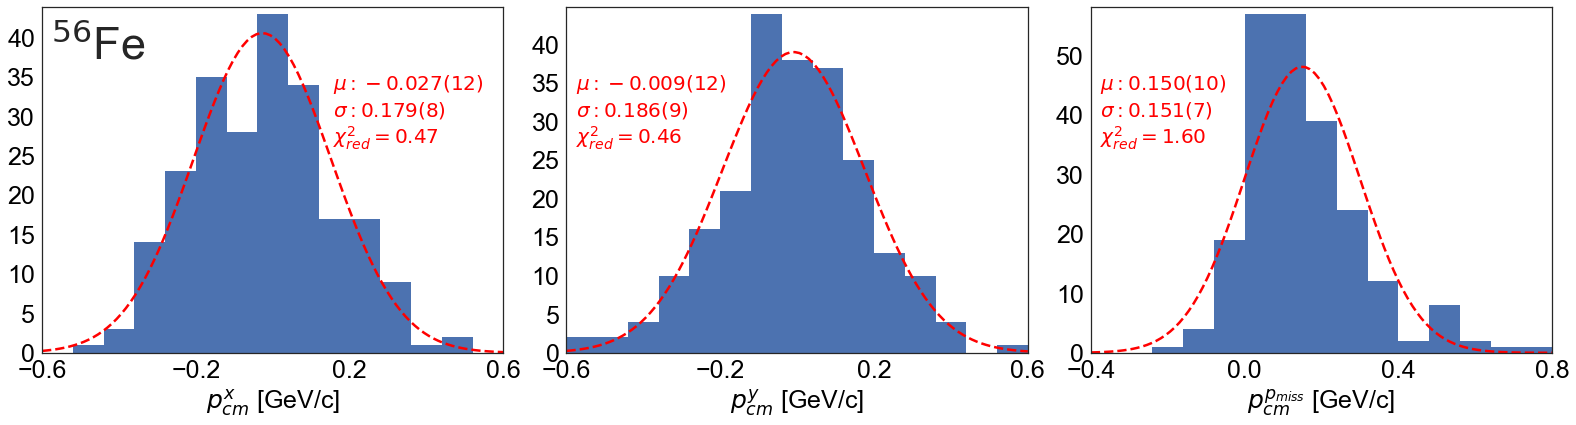

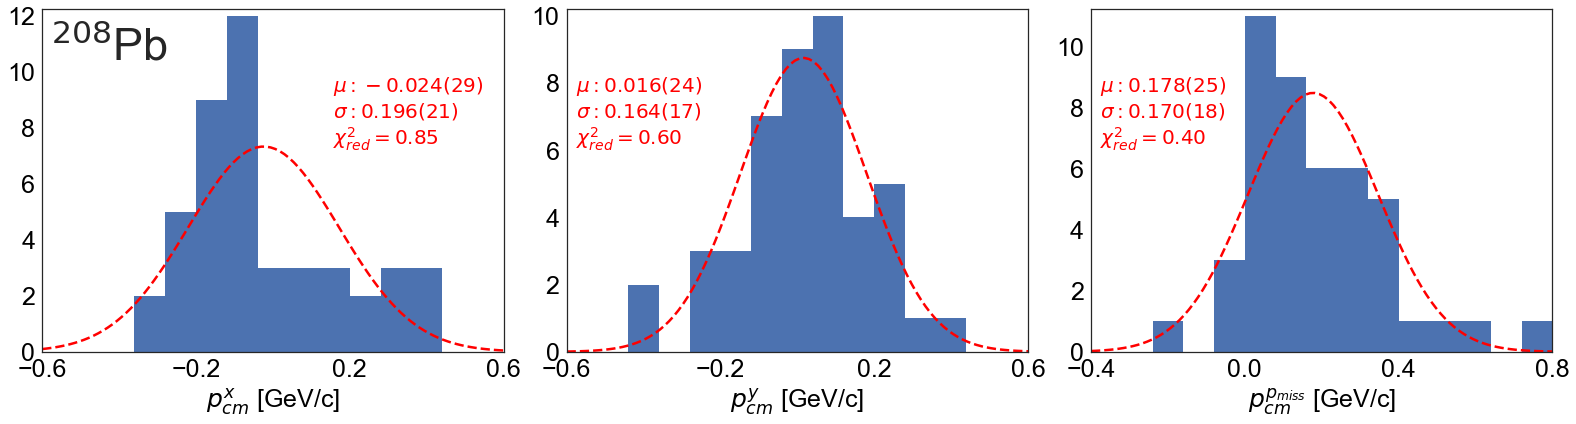

In [5]:
for target,name in zip(['C12','Al27','Fe56','Pb208']
                       ,['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb']):
    fig=plt.figure(figsize=(22,6))
    for i,(cm_pars_dir,direction,label) in enumerate(zip(['x','y','z']
                                                         ,['X','Y','Z']                                             
                                                         ,['x','y','p_{miss}'])):
        ax=fig.add_subplot(1,3,i+1)
        x = data300Pmiss600_PrecFid[target]['pcm'+direction]
        xmin = -0.6 if i<2 else -0.4       
        xmax = 0.6 if i<2 else 0.8
        bins=np.linspace(xmin,xmax,16)

        h,bins,_=plt.hist( x,  bins=bins)
        NormFact = len(x)*(bins[1]-bins[0])
        cm_pars_target = cm_pars[cm_pars['target']==name]
        mean = float(cm_pars_target['mean_'+cm_pars_dir+'_unweighted'])
        mean_err = float(cm_pars_target['mean_'+cm_pars_dir+'Err_unweighted'])
        sigma = float(cm_pars_target['sigma_'+cm_pars_dir+'_unweighted'])
        sigma_err = float(cm_pars_target['sigma_'+cm_pars_dir+'Err_unweighted'])
        chi2red = float(cm_pars_target['chi2red_'+cm_pars_dir+'_unweighted'])


        set_axes(ax,'$p_{cm}^{%s}$ [GeV/c]'%label, xticks=np.linspace(xmin,xmax,4))
        x_v = np.linspace(xmin,xmax,100)
        plt.plot( x_v , NormFact*mlab.normpdf(x_v, mean, sigma),'--',color='red',linewidth=2.5)
        ax.set_xlim(xmin,xmax)
        ax.set_ylim(0,1.02*np.max(h))

        xtext = xmin+0.02*(xmax-xmin) 
        if direction=='X': 
            plt.text( xtext, 0.85*np.max(ax.get_ylim()), name , fontsize=45)
        # parametrs on text
        if target!='C12' and direction=='X':
            xtext = xmax-0.37*(xmax-xmin) 
        plt.text( xtext, 0.6*np.max(ax.get_ylim()), '$\\mu:%.3f(%.0f)$\n$\\sigma:%.3f(%.0f)$\n$\chi^{2}_{red}=%.2f$'%(mean,1000*mean_err,sigma,1000*sigma_err,chi2red), color='red' , fontsize=20)

        
    plt.tight_layout()
    outfilename = figures_path+'MeasuredDistributions/MeasuredDistribution'+target+'.pdf' 
    print 'saved ' + outfilename
    plt.savefig(outfilename)

## momentum vectors of the final-state protons

In [6]:
theta_line = np.linspace(20,120,50)

In [7]:
mom = 0.3

def fa(p):
    return p[0] + p[1]*np.exp(p[2]*(mom-p[3]))
def fb(p):
    return p[0] + p[1]*mom*np.exp(p[2]*np.square(mom-p[3]))
def ftheta_min(p):
    return p[0] + p[1]/np.square(mom) + p[2]*mom + p[3]/mom + p[4]*np.exp(p[5]*mom)

def phi_limits(sector , DeltaPhi_min, DeltaPhi_max):
    return (60.*sector - DeltaPhi_min) , (60.*sector + DeltaPhi_max)
def Delta_phi(a,theta_min,b):
    return (a * (1 - 1./( ((theta_line - theta_min)/b) + 1 ) ))

In [8]:
# sectors:
phi_min_array,phi_max_array=[],[]

# sector 1
DeltaPhi_min=Delta_phi( fa([25,-12,1.644,4.4]),ftheta_min([7,0.207,0.169,0.1,0.1,-0.1]),fb([4,2,-0.978,0.5]))
DeltaPhi_max=Delta_phi(fa([25,-11.9735,0.803,4.4]),ftheta_min([7,0.207,0.169,0.1,0.1,-0.1]),fb([2.53,0.442,-2,1.02]))
phi_min_max = phi_limits(sector=1 , DeltaPhi_min=DeltaPhi_min, DeltaPhi_max=DeltaPhi_max)
phi_min_array.append(phi_min_max[0])
phi_max_array.append(phi_min_max[1])

# sector 2
DeltaPhi_min=Delta_phi( fa([25.,-12.,1.519,4.4]),ftheta_min([5.5,0.1,0.506,0.1,3.307,-0.652]),fb([4.,2.,-2.,0.5]))
DeltaPhi_max=Delta_phi(fa([24.81,-8.,0.85,4.8]),ftheta_min([5.5,0.1,0.506,0.1,3.307,-0.652]),fb([2.65,0.201,-0.179,1.6]))
phi_min_max = phi_limits(sector=2 , DeltaPhi_min=DeltaPhi_min, DeltaPhi_max=DeltaPhi_max)
phi_min_array.append(phi_min_max[0])
phi_max_array.append(phi_min_max[1])

# sector 3
DeltaPhi_min=Delta_phi( fa([25.,-12.,1.1095,4.4]),ftheta_min([7.06,0.127,-0.066,0.100,4.499,-3.17]),fb([2.784,2,-1.73,0.5]))
DeltaPhi_max=Delta_phi(fa([24.87,-8.,1.0125,4.8]),ftheta_min([7.06,0.127,-0.066,0.100,4.499,-3.17]),fb([3.17,1.275,-2,0.5]))
phi_min_max = phi_limits(sector=3 , DeltaPhi_min=DeltaPhi_min, DeltaPhi_max=DeltaPhi_max)
phi_min_array.append(phi_min_max[0])
phi_max_array.append(phi_min_max[1])

# sector 4
DeltaPhi_min=Delta_phi( fa([25.,-12.,0.9778,4.4]),ftheta_min([6.32,0.1,0.2217,0.1,5.31,-3.3]),fb([3.58,1.38,-2,0.5]))
DeltaPhi_max=Delta_phi(fa([25,-12,0.911,4.4]),ftheta_min([6.32,0.1,0.2217,0.1,5.31,-3.3]),fb([2.47,1.76,-1.894,1.04]))
phi_min_max = phi_limits(sector=4 , DeltaPhi_min=DeltaPhi_min, DeltaPhi_max=DeltaPhi_max)
phi_min_array.append(phi_min_max[0])
phi_max_array.append(phi_min_max[1])

# sector 5
DeltaPhi_min=Delta_phi( fa([25.,-12.,0.955366,4.4]),ftheta_min([5.5,0.211,0.6409,0.1,3.2,-1.108]),fb([3.32277,0.041,-0.954,0.5]))
DeltaPhi_max=Delta_phi(fa([25.,-8.526,0.683,4.8]),ftheta_min([5.5,0.211,0.6409,0.1,3.2,-1.108]),fb([2.424,1.254,-2,0.8157]))
phi_min_max = phi_limits(sector=5 , DeltaPhi_min=DeltaPhi_min, DeltaPhi_max=DeltaPhi_max)
phi_min_array.append(phi_min_max[0])
phi_max_array.append(phi_min_max[1])

# sector 6
DeltaPhi_min=Delta_phi( fa([25.,-12.,0.969,4.4]),ftheta_min([5.5,0.2816,0.358,0.1,0.776,-0.46]),fb([4,2,-2,1.086]))
DeltaPhi_max=Delta_phi(fa([25,-8,0.888,4.8]),ftheta_min([5.5,0.2816,0.358,0.1,0.776,-0.46]),fb([2.64,0.159,-2,1.31]))
phi_min_max = phi_limits(sector=0 , DeltaPhi_min=DeltaPhi_min, DeltaPhi_max=DeltaPhi_max)
phi_min_array.append(phi_min_max[0])
phi_max_array.append(phi_min_max[1])

phi_sector = [0.5*(phi_max_array[0]+phi_min_array[1])
                      ,0.5*(phi_max_array[1]+phi_min_array[2])
                      ,0.5*(phi_max_array[2]+phi_min_array[3])
                      ,0.5*(phi_max_array[3]+phi_min_array[4])
                      ,0.5*(phi_max_array[4]+phi_min_array[5])
                      ,0.5*(phi_max_array[5]+phi_min_array[0])]



saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/PleadPrecoil_C12.pdf
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/PleadPrecoil_Al27.pdf
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/PleadPrecoil_Fe56.pdf
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/PleadPrecoil_Pb208.pdf


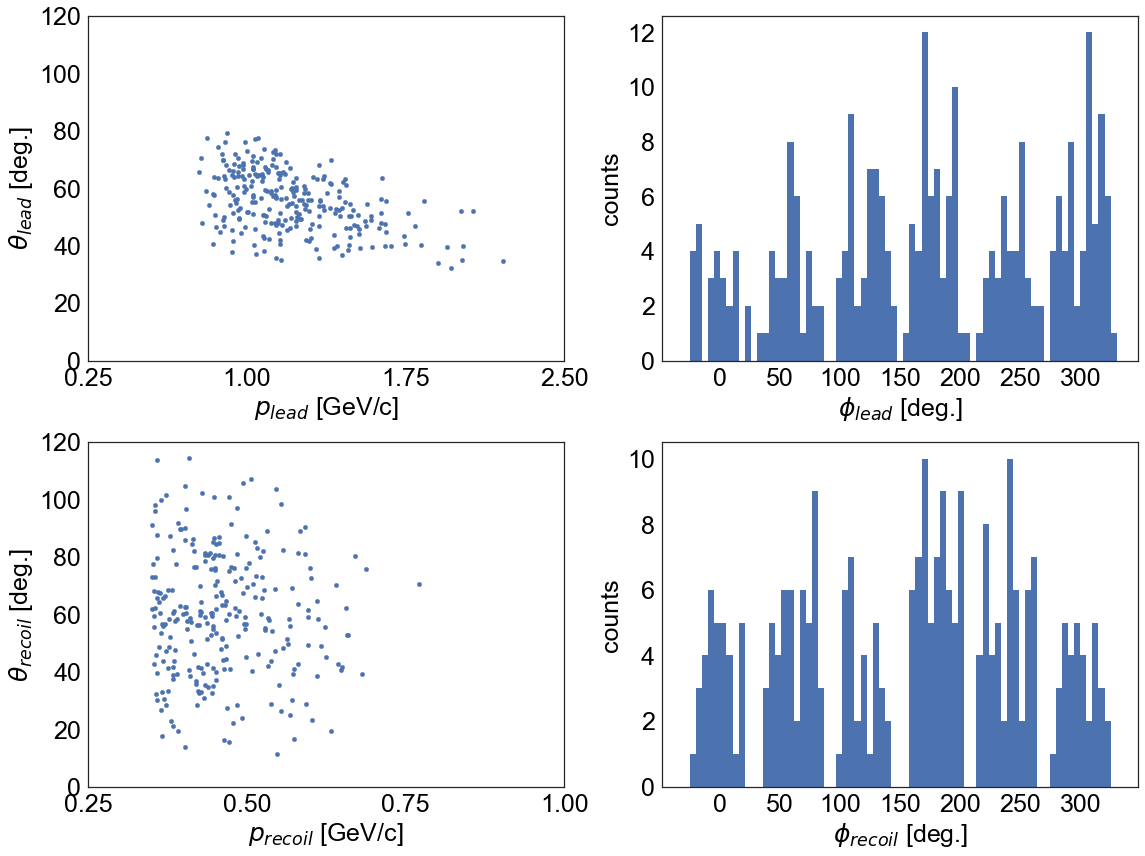

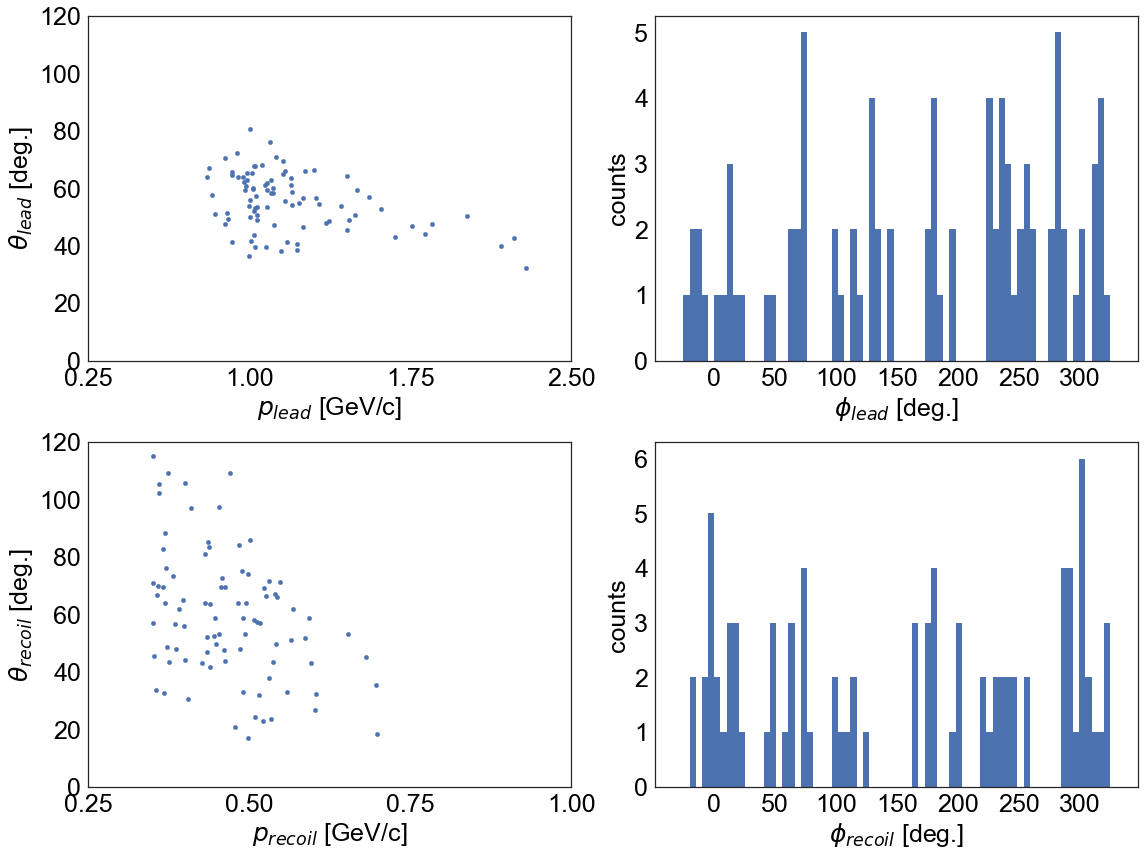

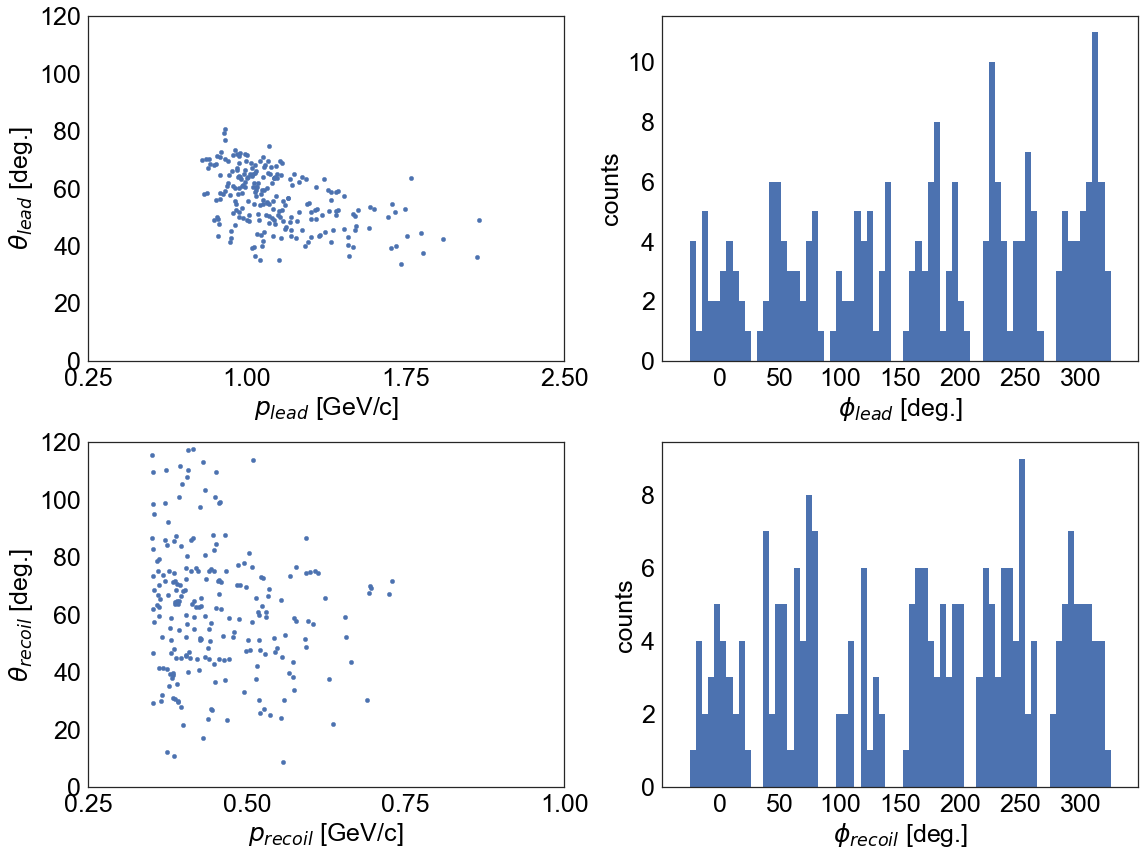

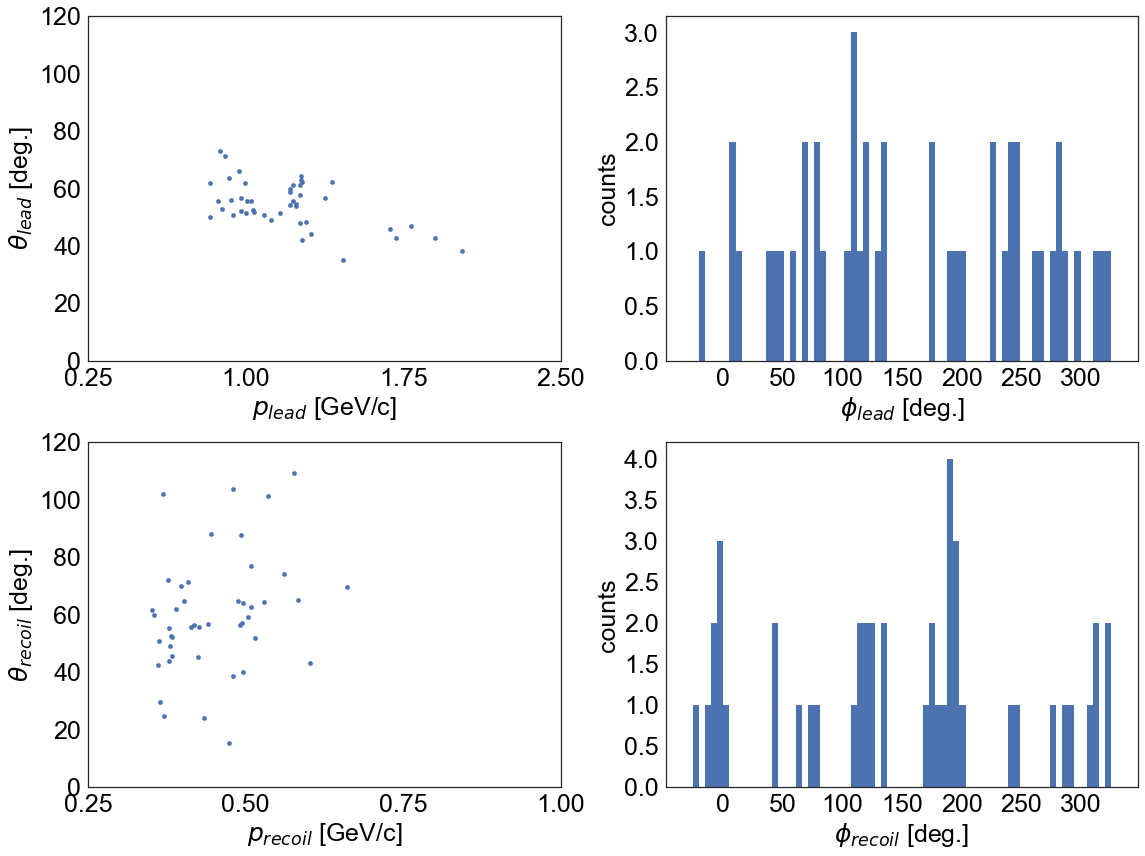

In [21]:
for target,name in zip(['C12','Al27','Fe56','Pb208']
                       ,['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb']):
    fig = plt.figure(figsize=(16,12))    
    for i_proton,proton in enumerate(['lead','recoil']):

        P = data300Pmiss600_PrecFid[target]['P'+proton+'_P']
        theta = 180./np.pi*data300Pmiss600_PrecFid[target]['P'+proton+'_theta']
        phi = data300Pmiss600_PrecFid[target]['P'+proton+'_phi']
        
        ax = fig.add_subplot(2,2,2*i_proton+1)
        plt.scatter(P,theta,s=20)
        set_axes(ax,r'$p_{%s}$ [GeV/c]'%proton,r'$\theta_{%s}$ [deg.]'%proton
                 , xlim=(0.25,2.5) if i_proton==0 else (0.25,1.0)
                 , xticks=np.linspace(0.25,2.5,4) if i_proton==0 else np.linspace(0.25,1,4)
                 , ylim=(0,120)
                )       
        
        ax = fig.add_subplot(2,2,2*i_proton+2)
        
        # draw the sectors in the recoil-proton case
#         if proton=='recoil' or proton=='lead':
#             for phi_s in phi_sector:                
#                 plt.plot(theta_line,phi_s,'--',color='red',linewidth=2,alpha=1)
#                 plt.plot([np.average(phi_s),np.average(phi_s)],ax.get_ylim(),'--',color='red',linewidth=2,alpha=1)
#             for phi_min,phi_max in zip(phi_min_array,phi_max_array):
#                 plt.plot(theta_line,phi_min,'--',color='black',linewidth=2,alpha=0.5)
#                 plt.plot(theta_line,phi_max,'--',color='black',linewidth=2,alpha=0.5)
                
        plt.hist(phi,bins=np.linspace(-30,330,72))
#         plt.scatter(theta,phi,s=20)

        set_axes(ax
#                  ,r'$\theta_{%s}$ [deg.]'%proton
                 ,r'$\phi_{%s}$ [deg.]'%proton
                 ,'counts'
#                  , xlim=(0,120)
#                  , ylim=(-30,330)
                )
#         for phi_s in phi_sector:                
#             plt.plot([np.average(phi_s),np.average(phi_s)],ax.get_ylim(),'--',color='red',linewidth=2,alpha=1)

    plt.tight_layout()
    outfilename = figures_path+'MeasuredDistributions/PleadPrecoil_'+target+'.pdf' 
    print 'saved ' + outfilename
    plt.savefig(outfilename)

## lab $\phi$ difference between the electron and the recoil proton

saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/phi_lab_ep.pdf


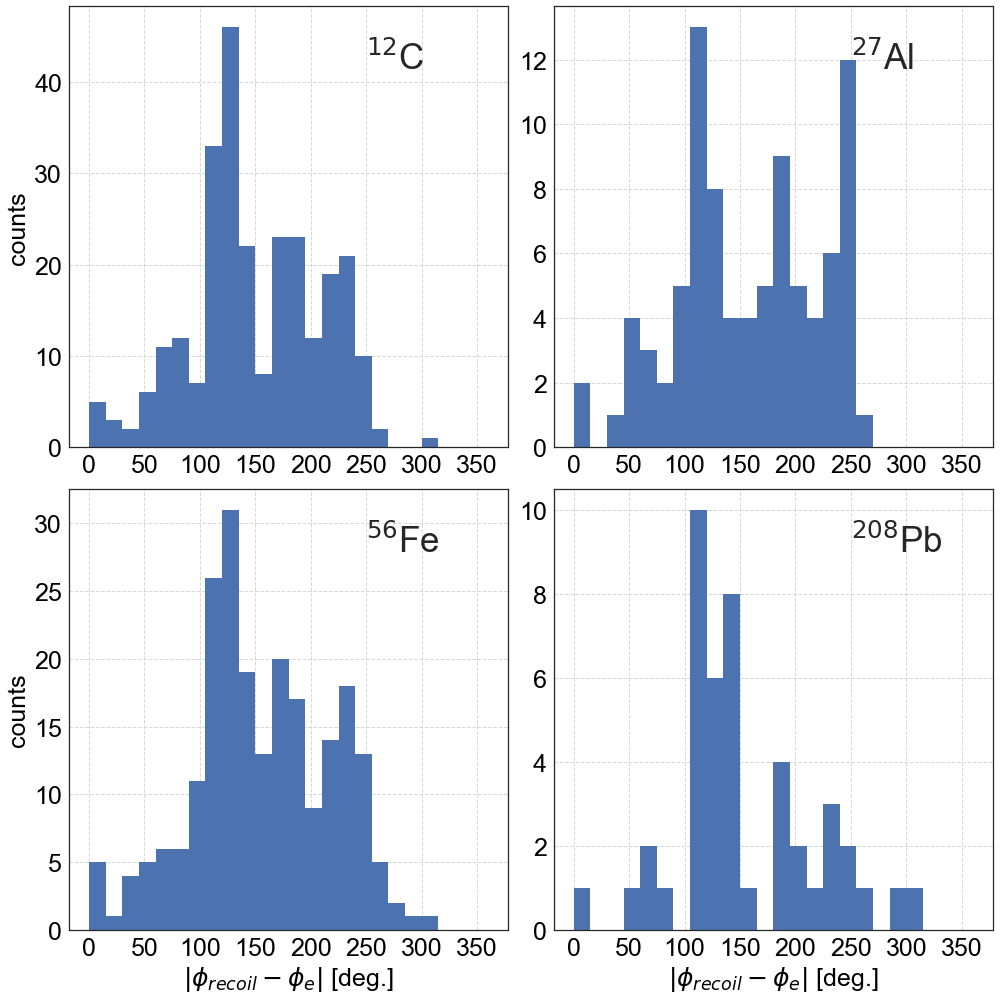

In [22]:
fig = plt.figure(figsize=(14,14))
for i_tgt,(target,name) in enumerate(zip(['C12','Al27','Fe56','Pb208']
                       ,['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb'])):    
    delta_phi = (data300Pmiss600_PrecFid[target]['Precoil_phi']-data300Pmiss600_PrecFid[target]['electron_phi'])
    ax = fig.add_subplot(2,2,i_tgt+1)
    h,bins,_=plt.hist(np.abs(delta_phi),bins=np.linspace(0,360,25))
    plt.text(250,0.9*np.max(h),name,fontsize=35)
    set_axes(ax,r'$|\phi_{recoil} - \phi_{e}|$ [deg.]' if i_tgt>1 else ''
                 ,'counts' if i_tgt==0 or i_tgt==2 else '',do_add_grid=True
                )
plt.tight_layout()
outfilename = figures_path+'MeasuredDistributions/phi_lab_ep.pdf' 
print 'saved ' + outfilename
plt.savefig(outfilename)

saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/delta_phi_vs_delta_theta_lab_ep.pdf


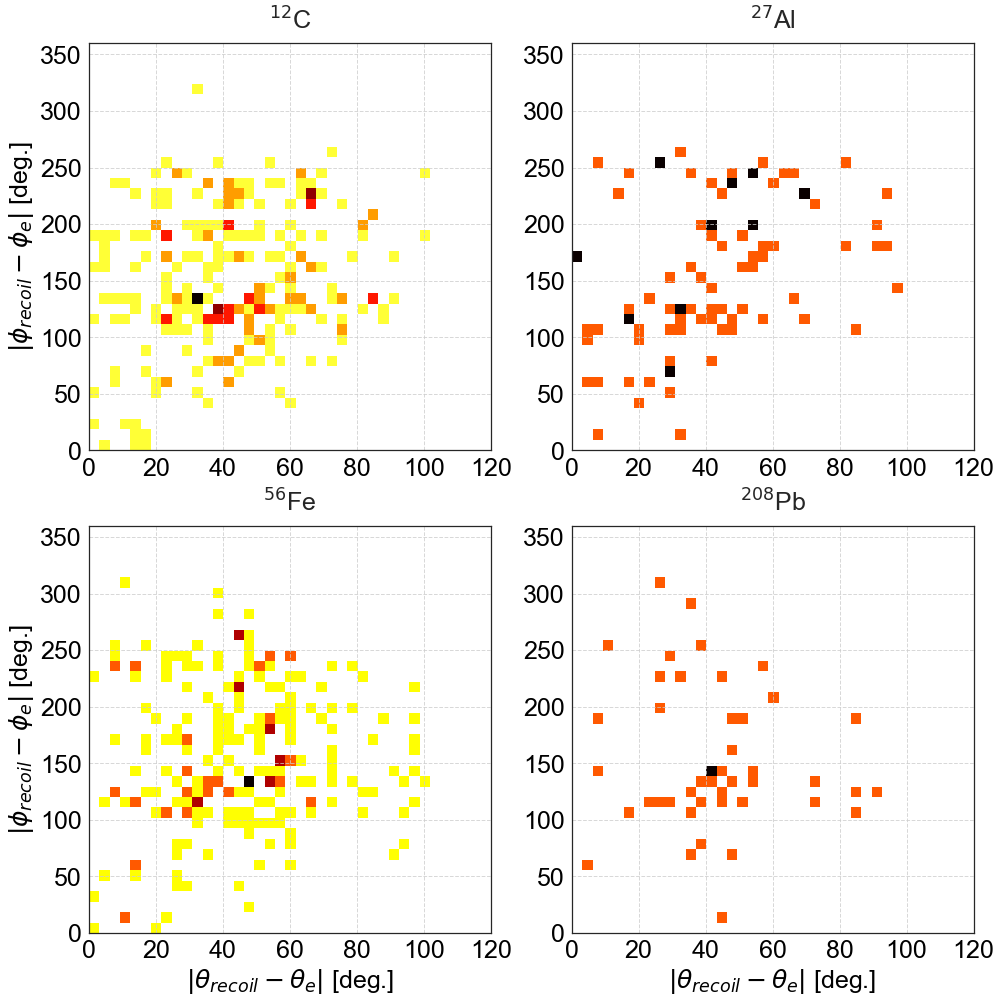

In [23]:
fig = plt.figure(figsize=(14,14))
for i_tgt,(target,name) in enumerate(zip(['C12','Al27','Fe56','Pb208']
                       ,['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb'])):    
    delta_phi = (data300Pmiss600_PrecFid[target]['Precoil_phi']-data300Pmiss600_PrecFid[target]['electron_phi'])
    delta_theta = 180./np.pi*(data300Pmiss600_PrecFid[target]['Precoil_theta']-data300Pmiss600_PrecFid[target]['electron_theta'])

    ax = fig.add_subplot(2,2,i_tgt+1)
    plot_2d_hist( np.abs(delta_theta),np.abs(delta_phi),bins=(np.linspace(0,120,40),np.linspace(0,360,40)),ax=ax)
    set_axes(ax
             ,r'$|\theta_{recoil} - \theta_{e}|$ [deg.]' if i_tgt>=2 else ''
             ,r'$|\phi_{recoil} - \phi_{e}|$ [deg.]' if i_tgt==0 or i_tgt==2 else ''
             ,title=name
             ,do_add_grid=True
                )
plt.tight_layout()
outfilename = figures_path+'MeasuredDistributions/delta_phi_vs_delta_theta_lab_ep.pdf'
print 'saved ' + outfilename
plt.savefig(outfilename)

## the c.m. distributions witouth a cut on $p_{miss}<600$

504 events
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/MeasuredDistribution_all_Pmiss_C12.pdf
175 events
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/MeasuredDistribution_all_Pmiss_Al27.pdf
475 events
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/MeasuredDistribution_all_Pmiss_Fe56.pdf
108 events
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/MeasuredDistribution_all_Pmiss_Pb208.pdf


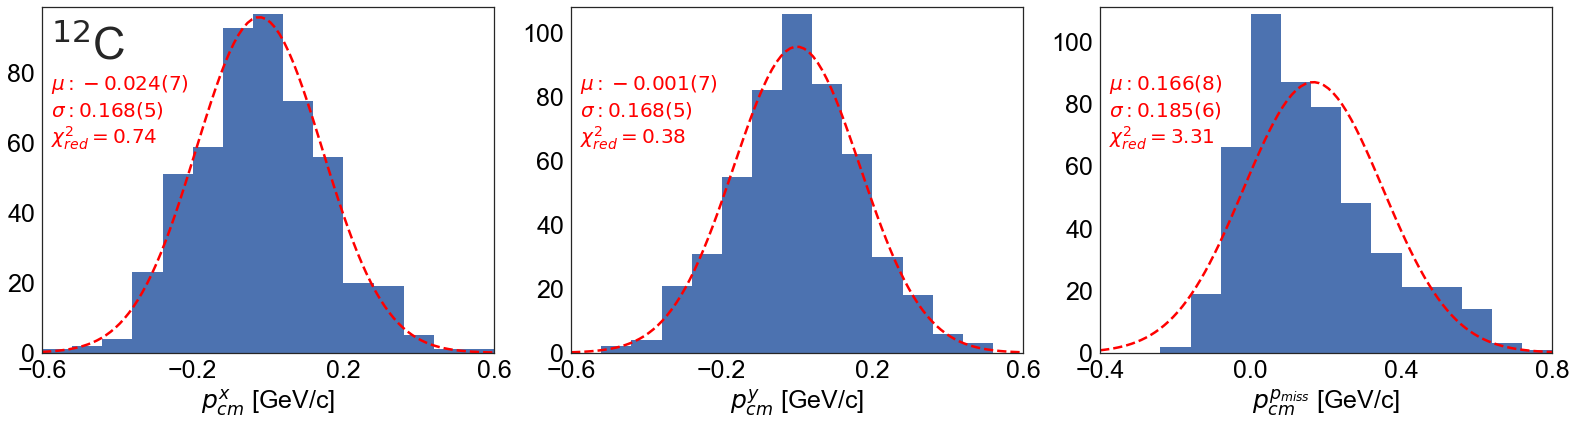

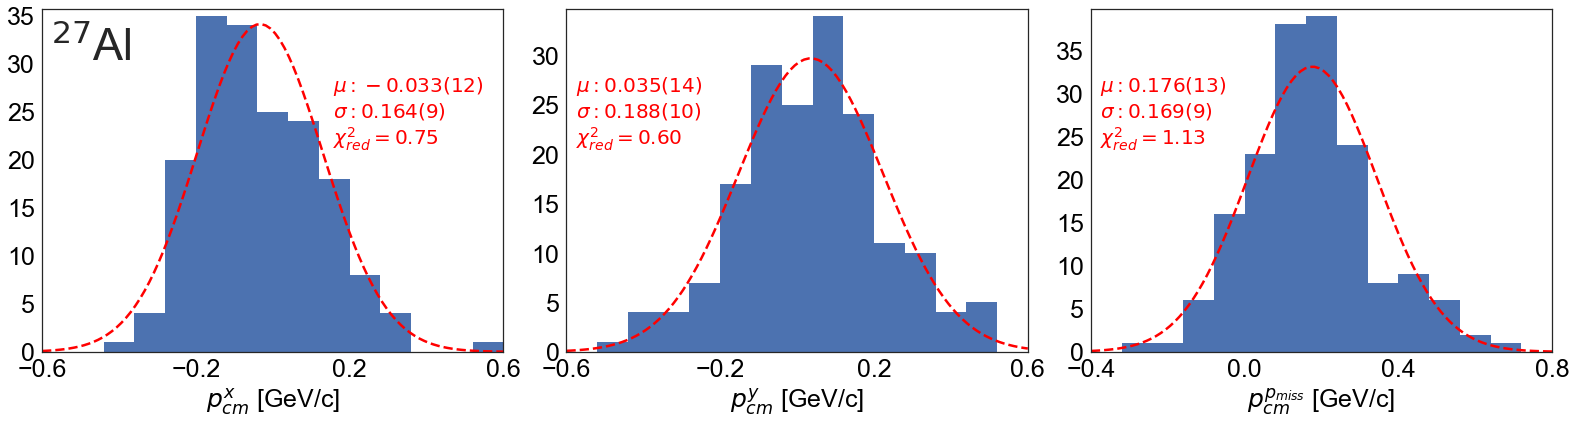

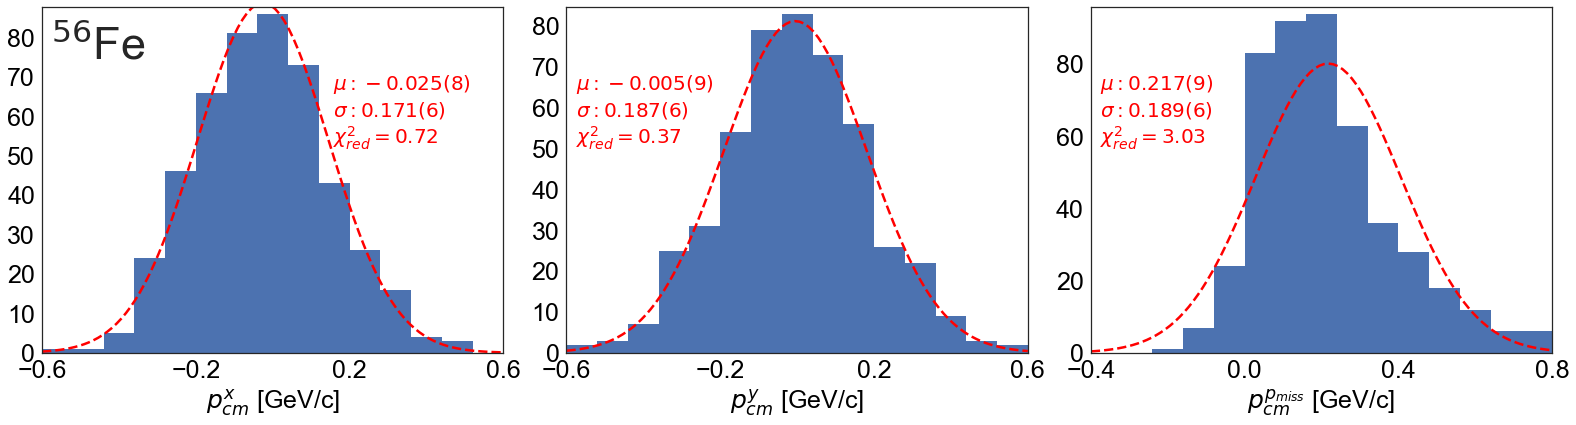

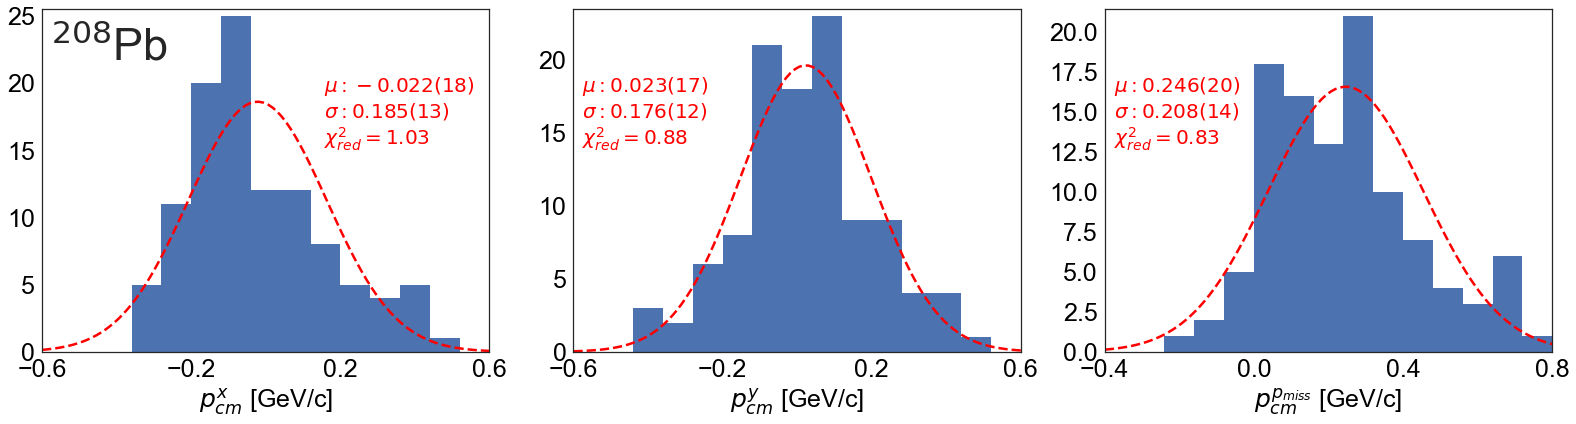

In [8]:
cm_parameters = dict()
cm_parameters_with_correction = dict()
cm_pars_all_Pmiss = pd.read_csv('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/300Pmiss1000/alltargets_PrecFiducials_dataCMparameters.csv')
for direction in ['x','y']:
    cm_pars_all_Pmiss['sigma_'+direction+'_before_acc_corr'] = np.sqrt(np.square(cm_pars_all_Pmiss['sigma_'+direction+'_unweighted']) - np.square(0.02))
    cm_pars_all_Pmiss['sigma_'+direction+'_before_acc_corr_err'] = cm_pars_all_Pmiss['sigma_'+direction+'Err_unweighted']

for target,name in zip(['C12','Al27','Fe56','Pb208']
                       ,['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb']):
    fig=plt.figure(figsize=(22,6))
    for i,(cm_pars_dir,direction,label) in enumerate(zip(['x','y','z']
                                                         ,['X','Y','Z']                                             
                                                         ,['x','y','p_{miss}'])):
        ax=fig.add_subplot(1,3,i+1)
        x = data_allPmiss_PrecFid[target]['pcm'+direction]
        if i==0: print len(x),'events'
        xmin = -0.6 if i<2 else -0.4       
        xmax = 0.6 if i<2 else 0.8
        bins=np.linspace(xmin,xmax,16)

        h,bins,_=plt.hist( x,   bins=bins)
        NormFact = len(x)*(bins[1]-bins[0])
        cm_pars_target = cm_pars_all_Pmiss[cm_pars_all_Pmiss['target']==name]
        mean = float(cm_pars_target['mean_'+cm_pars_dir+'_unweighted'])
        mean_err = float(cm_pars_target['mean_'+cm_pars_dir+'Err_unweighted'])
        sigma = float(cm_pars_target['sigma_'+cm_pars_dir+'_unweighted'])
        sigma_err = float(cm_pars_target['sigma_'+cm_pars_dir+'Err_unweighted'])
        chi2red = float(cm_pars_target['chi2red_'+cm_pars_dir+'_unweighted'])


        set_axes(ax,'$p_{cm}^{%s}$ [GeV/c]'%label, xticks=np.linspace(xmin,xmax,4))
        x_v = np.linspace(xmin,xmax,100)
        plt.plot( x_v , NormFact*mlab.normpdf(x_v, mean, sigma),'--',color='red',linewidth=2.5)
        ax.set_xlim(xmin,xmax)
        ax.set_ylim(0,1.02*np.max(h))

        xtext = xmin+0.02*(xmax-xmin) 
        if direction=='X': 
            plt.text( xtext, 0.85*np.max(ax.get_ylim()), name , fontsize=45)
        # parametrs on text
        if target!='C12' and direction=='X':
            xtext = xmax-0.37*(xmax-xmin) 
        plt.text( xtext, 0.6*np.max(ax.get_ylim()), '$\\mu:%.3f(%.0f)$\n$\\sigma:%.3f(%.0f)$\n$\chi^{2}_{red}=%.2f$'%(mean,1000*mean_err,sigma,1000*sigma_err,chi2red), color='red' , fontsize=20)

        
    plt.tight_layout()
    outfilename = figures_path+'MeasuredDistributions/MeasuredDistribution_all_Pmiss_'+target+'.pdf' 
    print 'saved ' + outfilename
    plt.savefig(outfilename)

## fit with simple binned fit

saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/binned_fits_C12.pdf
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/binned_fits_Al27.pdf
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/binned_fits_Fe56.pdf
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/binned_fits_Pb208.pdf


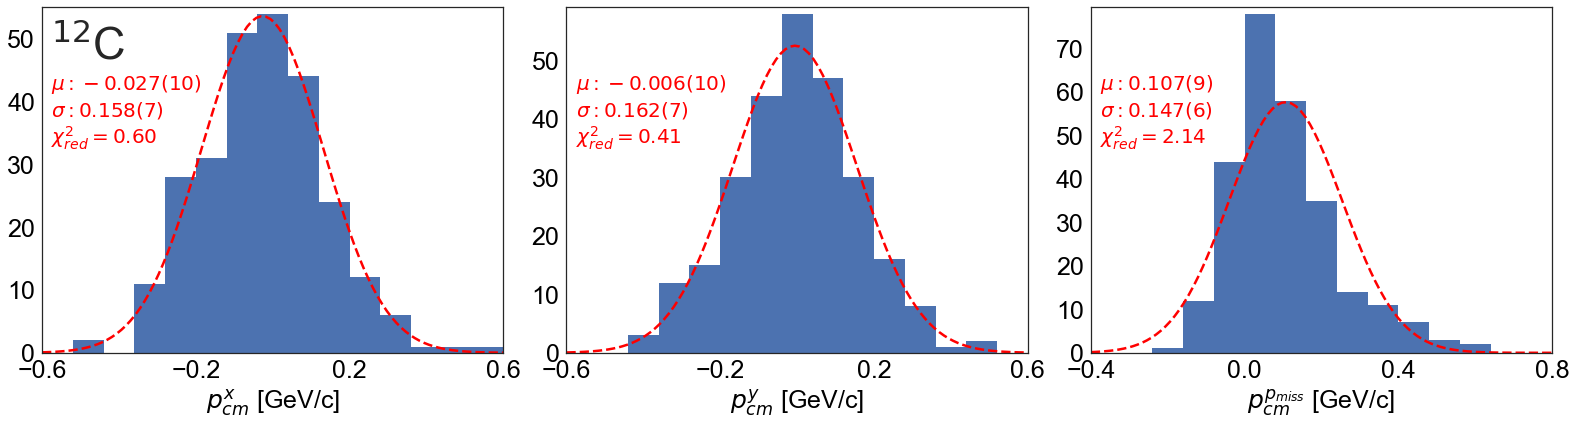

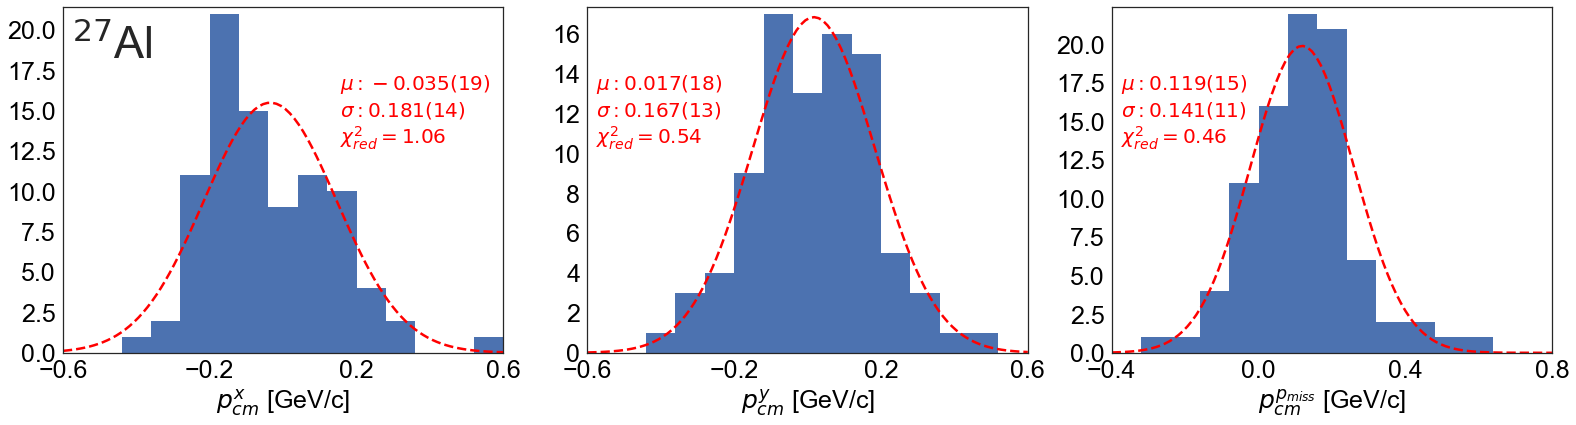

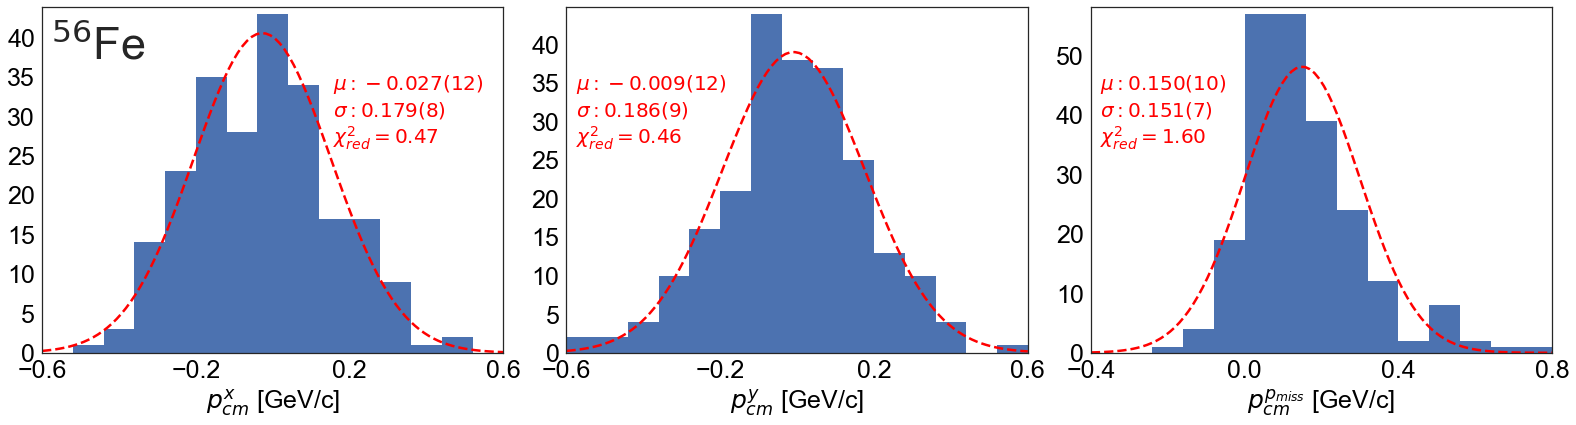

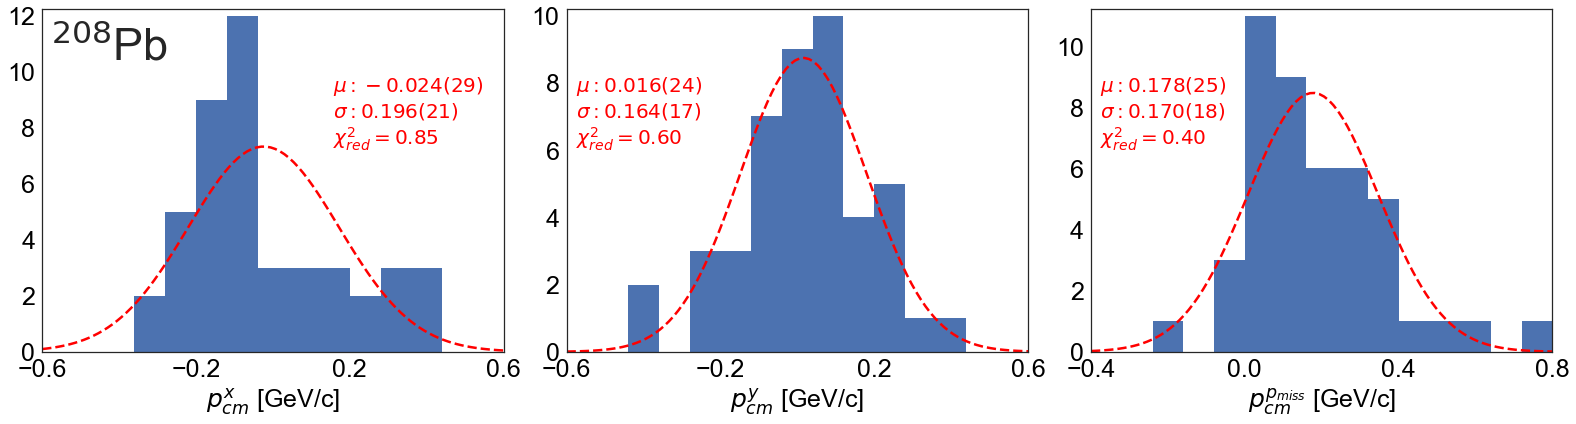

In [8]:
for target,name in zip(['C12','Al27','Fe56','Pb208']
                       ,['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb']):
    fig=plt.figure(figsize=(22,6))
    for i,(cm_pars_dir,direction,label) in enumerate(zip(['x','y','z']
                                                         ,['X','Y','Z']                                             
                                                         ,['x','y','p_{miss}'])):
        ax=fig.add_subplot(1,3,i+1)
        x = data300Pmiss600_PrecFid[target]['pcm'+direction]
        xmin = -0.6 if i<2 else -0.4       
        xmax = 0.6 if i<2 else 0.8
        bins=np.linspace(xmin,xmax,16)
        h,bins,_=plt.hist( x,  bins=bins)
        NormFact = len(x)*(bins[1]-bins[0])
        
        cm_pars_target = cm_pars[cm_pars['target']==name]
        mean = float(cm_pars_target['mean_'+cm_pars_dir+'_unweighted'])
        mean_err = float(cm_pars_target['mean_'+cm_pars_dir+'Err_unweighted'])
        sigma = float(cm_pars_target['sigma_'+cm_pars_dir+'_unweighted'])
        sigma_err = float(cm_pars_target['sigma_'+cm_pars_dir+'Err_unweighted'])
        chi2red = float(cm_pars_target['chi2red_'+cm_pars_dir+'_unweighted'])


        set_axes(ax,'$p_{cm}^{%s}$ [GeV/c]'%label, xticks=np.linspace(xmin,xmax,4))
        x_v = np.linspace(xmin,xmax,100)
        plt.plot( x_v , NormFact*mlab.normpdf(x_v, mean, sigma),'--',color='red',linewidth=2.5)
        ax.set_xlim(xmin,xmax)
        ax.set_ylim(0,1.02*np.max(h))

        xtext = xmin+0.02*(xmax-xmin) 
        if direction=='X': 
            plt.text( xtext, 0.85*np.max(ax.get_ylim()), name , fontsize=45)
        # parametrs on text
        if target!='C12' and direction=='X':
            xtext = xmax-0.37*(xmax-xmin) 
        plt.text( xtext, 0.6*np.max(ax.get_ylim()), '$\\mu:%.3f(%.0f)$\n$\\sigma:%.3f(%.0f)$\n$\chi^{2}_{red}=%.2f$'%(mean,1000*mean_err,sigma,1000*sigma_err,chi2red), color='red' , fontsize=20)

        
    plt.tight_layout()
    outfilename = figures_path+'MeasuredDistributions/binned_fits_'+target+'.pdf' 
    print 'saved ' + outfilename
    plt.savefig(outfilename)

In [12]:
import kafe
from kafe.function_library import gauss
import iminuit

In [38]:

x = data300Pmiss600_PrecFid['C12']['pcmY']
h, edges = np.histogram(x, bins=bins)
h =h.astype(np.float)/np.sum(h)
centers = 0.5*(edges[:-1] + edges[1:]) ; bin_width = centers[1]-centers[0]

hdataset = kafe.Dataset([centers, h])
# hdataset.add_error_source('y', 'simple', np.sqrt(h))
covmat = hdataset.get_cov_mat('y')
for i in range(0, len(covmat)):
    if covmat[i, i] == 0.:
        covmat[i, i] = 1.
hdataset.set_cov_mat('y', covmat) # write it back

# Fit
hfit = kafe.Fit(hdataset, gauss, fit_label="Fit of a Gaussian to histogram data", quiet=True)
hfit.call_minimizer(final_fit=False, verbose=False)
fdata=hfit.fit_function.evaluate(hfit.xdata, hfit.current_parameter_values)
np.fill_diagonal(covmat, fdata)
hfit.current_cov_mat = covmat  # write back new covariance matrix
print 'np.std(x):',np.std(x)
print 'bin_width:',bin_width
sum_h = np.sum([h[i]*bin_width for i in range(len(h))])
h_avg = np.sum([h[i]*centers[i]*bin_width for i in range(len(h))])/sum_h
print 'histogram average:',h_avg
variance = (np.sum([h[i]*(centers[i]*centers[i])*bin_width for i in range(len(h))])/sum_h - h_avg*h_avg)
print 'histogram variance:',variance
print 'histogram std:',np.sqrt(variance)


hfit.set_parameters([np.mean(x),np.std(x),1])
hfit.fix_parameters('mean')
hfit.do_fit(quiet=True)

mean, sigma , scale = hfit.get_parameter_values()
mean_err, sigma_err , scale_err = hfit.get_parameter_errors()

print 'mean=%.3f+/-%.3f, sigma=%.3f+/-%.3f , scale=%.1f+/-%.1f:'%(mean,mean_err, sigma, sigma_err , scale,scale_err)
# hplot = kafe.Plot(hfit)

kafe 2018-01-06 19:21:16,918 :: WARNING :: Parameter starting errors not given. Setting to 1/10th of the parameter values.


np.std(x): 0.161643
bin_width: 0.08
histogram average: -0.00393939393939
histogram variance: 0.0250026629936
histogram std: 0.158122303909
mean=-0.006+/--0.000, sigma=0.164+/-0.098 , scale=0.2+/-0.2:


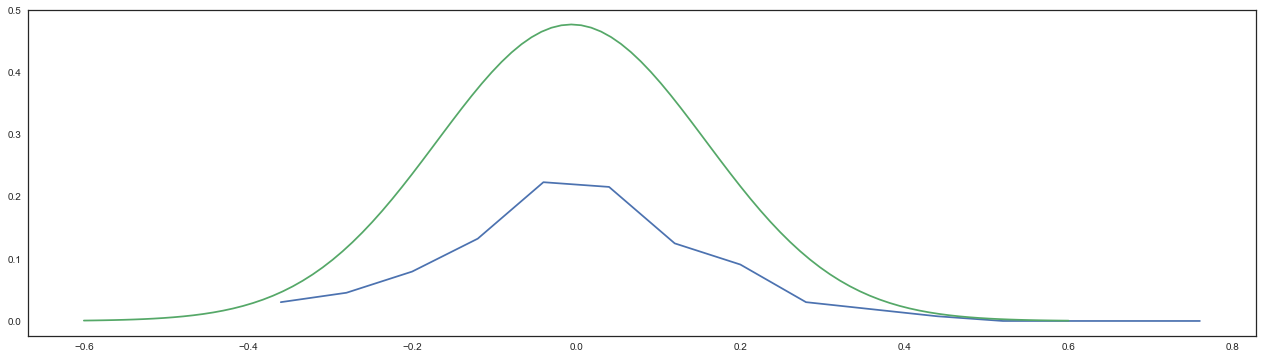

In [39]:
fig=plt.figure(figsize=(22,6))
ax = fig.add_subplot(111)
ax.plot( centers , h )
x_v = np.linspace(-0.6,0.6,100)
y_v = scale*mlab.normpdf(x_v, mean, sigma)
plt.plot(x_v,y_v)